<a href="https://colab.research.google.com/github/AlexeyTri/MyMachineLearningSeminars/blob/main/seminar18/%D0%9C%D0%BE%D0%B4%D0%B5%D0%BB%D0%B8_%D0%B2%D0%BD%D0%B8%D0%BC%D0%B0%D0%BD%D0%B8%D1%8F_%D0%B8_%D1%82%D1%80%D0%B0%D0%BD%D1%81%D1%84%D0%BE%D1%80%D0%BC%D0%B5%D1%80%D1%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Attention is all you need. Трансформеры.


#Бибилиотеки, загрузка данных, код обучения

*http://opus.nlpl.eu/Wikipedia-v1.0.php - выборка Wikipedia en-ru  и ru-en*

*https://github.com/AlexeyTri/MyMachineLearningSeminars/tree/main/seminar18*

*данные раземещены на GoogleDrive*


In [1]:
!pip install --quiet -U transformers torch sentencepiece

     |████████████████████████████████| 5.8 MB 5.5 MB/s 
     |████████████████████████████████| 1.3 MB 15.0 MB/s 
     |████████████████████████████████| 182 kB 49.6 MB/s 
     |████████████████████████████████| 7.6 MB 37.8 MB/s 


In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import gridspec

from tqdm.notebook import tqdm
import numpy as np
import  pandas as pd
import seaborn as sns
import torch
import scipy
# AutoModel это класс создающий зкземпляр соответствующей модели, с переданными на вход настроенными весами, конфигурацией и словарем
from transformers import AutoModel, AutoTokenizer
# конфигурация модели Marian https://huggingface.co/docs/transformers/v4.25.1/en/model_doc/marian#transformers.MarianConfig
# This model is also a PyTorch torch.nn.Module subclass. Use it as a regular PyTorch
from transformers import MarianMTModel, MarianTokenizer

from sklearn.metrics import classification_report
from torch.utils.tensorboard import SummaryWriter

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device


'cpu'

In [6]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [7]:
with open('/gdrive/MyDrive/Wikipedia.en-ru.en') as f:
    en_all_texts = f.read().splitlines()
with open('/gdrive/MyDrive/Wikipedia.en-ru.ru') as f:
    ru_all_texts = f.read().splitlines()

In [8]:
ru_texts = []
en_texts = []

for ru_text, en_text in zip(ru_all_texts, en_all_texts):
    if len(ru_text) < 100 and len(en_text) < 100:
        ru_texts.append(ru_text.lower())
        en_texts.append(en_text.lower())

In [9]:
len(ru_texts), len(en_texts)

(306887, 306887)

In [49]:
en_texts[:20]

['average temperatures on the coast are in january and in july.',
 'in march 2004, lithuania became a full member of the nato.',
 '73% of the population lives in urban areas while 27% in rural ones.',
 'association football is one of the most popular sports in modern russia.',
 'a. augustinavichiute and sources of socionics.',
 'j.',
 '1994.',
 '2006.',
 '1967.',
 '2004.',
 '1995.',
 'ed.',
 'the church of the tithes was chosen as the first cathedral temple.',
 '77.',
 'history of ukraine.',
 'the labor problem began with the industrialization of russia.',
 'all of these problems contributed to the popular uprising in russia in 1905.',
 'there is a statue of general f. s. marceau-desgraviers (b.',
 ') (1991).',
 'n,(2006).']

Блок кода для обучения

In [11]:
def train_on_batch(model, x_batch, y_batch, optimizer, loss_function):
    model.train()
    optimizer.zero_grad()

    output = model(x_batch.to(model.device), y_batch.to(model.device))

    loss = loss_function(output.transpose(1,2),
                         y_batch.to(model.device))
    
    loss.backward()
    optimizer.step()
    return loss.cpu().item()

TODO => CALLBACK

In [12]:
def train_epoch(train_generator, model, loss_function, optimizer, callback=None):
    epoch_loss = 0
    total = 0
    for it, (batch_of_x, batch_of_y) in enumerate(train_generator):
        batch_loss = train_on_batch(model, batch_of_x, batch_of_y, optimizer, loss_function)

        if callback is not None:
            with torch.no_grad():
                callback(model, batch_loss)
        epoch_loss += batch_loss*len(batch_of_x)
        total += len(batch_of_x)

    return epoch_loss/total

In [13]:
def trainer(count_of_epoch,
            batch_size,
            dataset,
            model,
            loss_function,
            optimizer,
            lr=0.001,
            callback=None):
    optima = optimizer(model.parameters(), lr=lr)

    iterations = tqdm(range(count_of_epoch), desc='epoch')
    iterations.set_postfix({'train epoch loss': np.nan})
    for it in iterations:
        batch_generator = tqdm(
            torch.utils.data.DataLoader(dataset=dataset,
                                        batch_size=batch_size,
                                        shuffle=True, pin_memory=True),
                               leave=False, total=len(dataset)//batch_size+(len(dataset)%batch_size>0))
        epoch_loss = train_epoch(train_generator=batch_generator,
                                 model=model,
                                 loss_function=loss_function,
                                 optimizer=optima,
                                 callback=callback)
        iterations.set_postfix({'train epoch loss': epoch_loss})

# Attn RNN


\begin{align}
        \mathbf{с} &= Attn(q,K,V)=\sum_{i=1} v_i SoftMax_i a(k_i,q)
    \end{align}

    * q - вектор-запрос, для которого хотим вычислить контекст
    * K = (к_1,...,k_n) - вектор-ключи, сравниваемые с запросом
    * V = (v_1,...,v_n) - векторы-значения, образующие контекст
    * a(k_i,q) - оценка релевантности (сходства) ключа k_i запросу q
    * c - искомый вектор контекста 

In [14]:
class Encoder(torch.nn.Module):
    @property
    def device(self):
        return next(self.parameters()).device

    def __init__(self, vocab_size, emb_dim=30, hidden_dim=30):
        super(Encoder, self).__init__()
        self.embedding = torch.nn.Embedding(vocab_size, emb_dim)
        self.lstm = torch.nn.LSTM(emb_dim, hidden_dim, batch_first=True)

    def forward(self, input):
        r'''
        :param input: тензор размера batch_size x seq_len --- список токенов
        '''

        act = self.embedding(input)
        act, hidden = self.lstm(act)
        return act, hidden


In [15]:
class Decoder(torch.nn.Module):
    @property
    def device(self):
        return next(self.parameters()).device

    def __init__(self, vocab_size, emb_dim=30, hidden_dim=30):
        super(Decoder, self).__init__()
        self.embedding = torch.nn.Embedding(vocab_size, emb_dim)
        self.attention = torch.nn.MultiheadAttention(emb_dim, 1)
        self.lstm = torch.nn.LSTM(emb_dim, hidden_dim, batch_first=True)
        self.linear = torch.nn.Linear(hidden_dim, vocab_size)

    def forward(self, input, encoder_outputs, hidden):
        r"""
        :param input: тензор размера batch_size x seq_len
        """
        act = self.embedding(input)
        act, _ = self.attention(act.transpose(0,1),
                                encoder_outputs.transpose(0,1),
                                encoder_outputs.transpose(0,1))
        act = act.transpose(0,1)
        act, hidden = self.lstm(act, hidden)
        return self.linear(act), hidden

In [16]:
class seq2seq(torch.nn.Module):
    @property
    def device(self):
        return next(self.parameters()).device
    
    def __init__(self, vocab_size, emb_dim=30, hidden_dim=30):
        super(seq2seq, self).__init__()
        self.vocab_size = vocab_size
        self.encoder = Encoder(vocab_size, emb_dim, hidden_dim)
        self.decoder = Decoder(vocab_size, emb_dim, hidden_dim)

    def forward(self, input, decoder_input=None, max_seq_len=64):
        r'''
        '''
        encoder_output, hidden = self.encoder(input)

        if decoder_input is None:
            translated_scores = torch.zeros(len(input),
                                            max_seq_len,
                                            self.vocab_size).to(self.device)
            translated_scores[:, 0, input[:,0]] = 1.
            for i in range(1, max_seq_len):
                translated_scores[:, i:i+1], hidden = self.decoder(
                    torch.argmax(translated_scores[:, i-1:i], axis=-1),
                    encoder_output,hidden)
        else:
            translated_scores, _ = self.decoder(decoder_input, encoder_output, hidden)
        return translated_scores

In [17]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-uncased', verbose=False)
tokenizer.vocab_size

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/872k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

105879

In [18]:
en_text_tenzors = tokenizer(en_texts[:20000],
                            return_tensors='pt', max_length=64, padding=True)
ru_text_tenzors = tokenizer(ru_texts[:20000],
                            return_tensors='pt', max_length=64, padding=True)

In [19]:
dataset_train_pt = torch.utils.data.TensorDataset(
    en_text_tenzors['input_ids'][:19000], ru_text_tenzors['input_ids'][:19000])
dataset_test_pt = torch.utils.data.TensorDataset(
    en_text_tenzors['input_ids'][19000:], ru_text_tenzors['input_ids'][19000:])

In [20]:
model = seq2seq(tokenizer.vocab_size)
model.to(device)

seq2seq(
  (encoder): Encoder(
    (embedding): Embedding(105879, 30)
    (lstm): LSTM(30, 30, batch_first=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(105879, 30)
    (attention): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=30, out_features=30, bias=True)
    )
    (lstm): LSTM(30, 30, batch_first=True)
    (linear): Linear(in_features=30, out_features=105879, bias=True)
  )
)

In [21]:
# https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
loss_function = torch.nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam

In [ ]:
trainer(count_of_epoch=15, 
        batch_size=64, 
        dataset=dataset_train_pt,
        model=model, 
        loss_function=loss_function,
        optimizer = optimizer,
        lr=0.001,
        callback=None)

In [22]:
tokens_en = tokenizer(['in 1924, most of the site was converted to a museum.'], return_tensors='pt')
tokens_ru = tokenizer(['в 1924 году крепость стала музеем'],return_tensors='pt')
with torch.no_grad():
    answer = torch.argmax(
        model(tokens_en['input_ids'].to(model.device),
              tokens_ru['input_ids'].to(model.device), max_seq_len=10),axis=-1)
tokenizer.decode(answer[0])

'##侬 nemetul historica historica historica historica historica historica historica'

In [23]:
with torch.no_grad():
    encoder_outputs, _=model.encoder(
        tokens_en['input_ids'].to(model.device))
    decoder_embedding = model.decoder.embedding(
        tokens_ru['input_ids'].to(model.device))
    
    act, act_weight = model.decoder.attention(
        decoder_embedding.transpose(0,1),
        encoder_outputs.transpose(0,1),
        encoder_outputs.transpose(0,1))

In [24]:
attention_frame = pd.DataFrame(
    act_weight[0].cpu().numpy(),
    index=tokenizer.convert_ids_to_tokens(
        tokens_ru['input_ids'][0].cpu().numpy()),
    columns=tokenizer.convert_ids_to_tokens(
        tokens_en['input_ids'][0].cpu().numpy()))

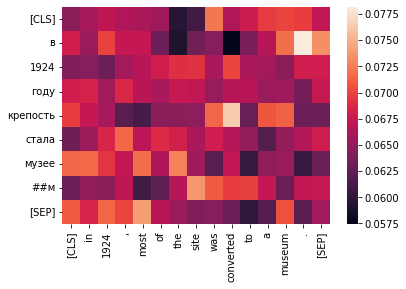

In [25]:
sns.heatmap(data=attention_frame)

plt.show()

# ТРАНСФОРМЕР

**seq2seq** -  RNN для снтеза последовательностей

In [26]:
class Encoder(torch.nn.Module):
    @property
    def device(self):
        return next(self.parameters()).device

    def __init__(self, vocab_size, emb_dim=30, hidden_dim=30):
        super(Encoder, self).__init__()
        self.layers = torch.nn.Sequential()
        self.embedding = torch.nn.Embedding(vocab_size, emb_dim)
        self.attention1 = torch.nn.MultiheadAttention(emb_dim, 1)
        self.linear1 = torch.nn.Linear(emb_dim, hidden_dim)
        self.relu = torch.nn.ReLU()
        self.attention2 = torch.nn.MultiheadAttention(hidden_dim,1)
        self.linear2 = torch.nn.Linear(hidden_dim, hidden_dim)

    def forward(self, input):
        r'''
        :param input: тензор размера batch_size x seq_len --- список токенов
        '''
        input = input.transpose(0,1)
        act = self.embedding(input)
        act, _ = self.attention1(act, act, act)
        act = self.relu(act)
        act = self.linear1(act)
        act = self.relu(act)
        act, _= self.attention2(act, act, act)
        act = self.relu(act)
        act = self.linear2(act)
        return act.transpose(0, 1)

In [27]:
class Decoder(torch.nn.Module):
    @property
    def device(self):
        return next(self.parameters()).device

    def __init__(self, vocab_size, emb_dim=30, hidden_dim=30):
        super(Decoder, self).__init__()
        self.embedding = torch.nn.Embedding(vocab_size, emb_dim)
        self.attention = torch.nn.MultiheadAttention(emb_dim, 1)
        self.linear1 = torch.nn.Linear(emb_dim, hidden_dim)
        self.relu = torch.nn.ReLU()

        self.attention2 = torch.nn.MultiheadAttention(hidden_dim, 1)
        self.linear2 = torch.nn.Linear(hidden_dim, hidden_dim)

        self.linear = torch.nn.Linear(hidden_dim, vocab_size)

    def forward(self, input, encoder_outputs):
        r'''
        :param input: тезор размера batch_size x seq_len
        '''
        input = input.transpose(0, 1)
        act = self.embedding(input)

        act, _ = self.attention(act, 
                                encoder_outputs.transpose(0, 1), 
                                encoder_outputs.transpose(0, 1))
        
        act = self.relu(act)
        act = self.linear1(act)
        act = self.relu(act)
        act, _ = self.attention2(act, 
                                 encoder_outputs.transpose(0, 1), 
                                 encoder_outputs.transpose(0, 1))
        act = self.relu(act)
        act = self.linear2(act)

        return self.linear(act).transpose(0, 1)


In [28]:
class seq2seq(torch.nn.Module):
    @property
    def device(self):
        return next(self.parameters()).device
    def __init__(self, vocab_size, emb_dim=30, hidden_dim=30):
        super(seq2seq, self).__init__()
        self.vocab_size = vocab_size
        self.encoder = Encoder(vocab_size, emb_dim, hidden_dim)
        self.decoder = Decoder(vocab_size, emb_dim, hidden_dim)

    def forward(self, input, decoder_input=None, max_seq_len=64):
        r'''
        '''
        encoder_output = self.encoder(input)
        if decoder_input is None:
            translated_scores = torch.zeros(len(input),
                                            max_seq_len,
                                            self.vocab_size).to(self.device)
            translated_scores[:,0,input[:,0]] = 1
            for i in range(1, max_seq_len):
                translated_scores[:, i:i+1] = self.decoder(
                    torch.argmax(translated_scores, axis=-1),
                    encoder_output)[:, i:i+1]
        else:
            translated_scores = self.decoder(
                decoder_input, encoder_output)
        return translated_scores

In [29]:
model = seq2seq(tokenizer.vocab_size)
model.to(device)

seq2seq(
  (encoder): Encoder(
    (layers): Sequential()
    (embedding): Embedding(105879, 30)
    (attention1): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=30, out_features=30, bias=True)
    )
    (linear1): Linear(in_features=30, out_features=30, bias=True)
    (relu): ReLU()
    (attention2): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=30, out_features=30, bias=True)
    )
    (linear2): Linear(in_features=30, out_features=30, bias=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(105879, 30)
    (attention): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=30, out_features=30, bias=True)
    )
    (linear1): Linear(in_features=30, out_features=30, bias=True)
    (relu): ReLU()
    (attention2): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=30, out_features=30, bias=True)
    )
    (linear2): Linear(in_features=30, out_features=

In [30]:
tokens_en = tokenizer(['in 1924, most of the site was converted to a museum.'],return_tensors='pt')
tokens_ru = tokenizer(['в 1924 году крепость стала музеем.'],return_tensors='pt')
with torch.no_grad():
    answer = torch.argmax(
        model(tokens_en['input_ids'].to(model.device),
              tokens_ru['input_ids'].to(model.device)),
              axis=-1
    )
tokenizer.decode(answer[0])

'##конаконаконаконаконаконаконаконаконакона'

In [31]:
loss_function = torch.nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam

In [32]:
trainer(count_of_epoch=5,
        batch_size=64,
        dataset=dataset_train_pt,
        model=model,
        loss_function=loss_function,
        optimizer=optimizer,
        lr=0.001,
        callback=None)

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/297 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [33]:
tokens_en = tokenizer(['in 1924, most of the site was converted to a museum.'], return_tensors='pt')
tokens_ru = tokenizer(['в 1924 году крепость стала музеем.'], return_tensors='pt')
with torch.no_grad():
    answer = torch.argmax(
        model(tokens_en['input_ids'].to(model.device), 
              tokens_ru['input_ids'].to(model.device)), 
        axis=-1)
tokenizer.decode(answer[0])

'##конаконаконаконаконаконаконаконаконакона'

# **Tensor2Tensor**

In [34]:
from transformers import MarianMTModel
tokenizer = MarianTokenizer.from_pretrained('Helsinki-NLP/opus-mt-ru-en')
model = MarianMTModel.from_pretrained('Helsinki-NLP/opus-mt-ru-en')
model.to(device)

Downloading:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/803k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.60M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/307M [00:00<?, ?B/s]

MarianMTModel(
  (model): MarianModel(
    (shared): Embedding(62518, 512, padding_idx=62517)
    (encoder): MarianEncoder(
      (embed_tokens): Embedding(62518, 512, padding_idx=62517)
      (embed_positions): MarianSinusoidalPositionalEmbedding(512, 512)
      (layers): ModuleList(
        (0): MarianEncoderLayer(
          (self_attn): MarianAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation_fn): SiLUActivation()
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          (final_layer_norm): LayerNorm((512,), eps=1

In [35]:
batch_x = tokenizer.prepare_seq2seq_batch(src_texts=['Привет мир, меня зовут Трансформер'],return_tensors='pt')

In [36]:
tokenizer.batch_decode(model.generate(**batch_x.to(device)))

['<pad> Hey, world, my name is Transformer.</s>']

# Токенизация Byte Pair Encoding **BPE**

In [37]:
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/LaBSE', verbose=False)
tokenizer.vocab_size

Downloading:   0%|          | 0.00/411 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/804 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.22M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.62M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

501153

In [38]:
tokenizer.tokenize('Hello Mathematic, my Name is Alexey, how are you&')

['Hello',
 'Math',
 '##emat',
 '##ic',
 ',',
 'my',
 'Name',
 'is',
 'Alexey',
 ',',
 'how',
 'are',
 'you',
 '&']

# Bidirectional Encoder Representations from Transfomers - BERT

In [39]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased', verbose=False)
model = AutoModel.from_pretrained('bert-base-multilingual-cased')
model.to(device)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
         

In [40]:
tokens = tokenizer(['Hello World','Alexey Litovchenko'], return_tensors='pt', padding=True)
with torch.no_grad():
    output =  model(**tokens.to(device))

In [41]:
tokens['input_ids']

tensor([[  101, 31178, 10315,   102,     0,     0,     0],
        [  101, 14728, 13005, 13258, 50996, 87665,   102]])

In [42]:
output[0].shape, output[1].shape

(torch.Size([2, 7, 768]), torch.Size([2, 768]))

In [43]:
tokens

{'input_ids': tensor([[  101, 31178, 10315,   102,     0,     0,     0],
        [  101, 14728, 13005, 13258, 50996, 87665,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1]])}

#Language-agnostic BERT Sentence Embedding **BERT**

In [44]:
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/LaBSE', 
                                          verbose=False)
model = AutoModel.from_pretrained('sentence-transformers/LaBSE')
model.to(device)


Downloading:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(501153, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
         

In [45]:
tokens = tokenizer(['Moscow Institute of Physics and Technology', 
                    'Московский Физико-Технический Институт', 
                    'Московский Государственный Университет', 
                    'Moscow State University'], 
                   return_tensors='pt', padding=True)

with torch.no_grad():
    output = model(**tokens.to(device))

sentence_embeding = output[1].cpu().numpy()

In [46]:
sentence_embeding.shape

(4, 768)

In [47]:
frame = pd.DataFrame(np.round(
    scipy.spatial.distance.cdist(sentence_embeding, sentence_embeding, 
                                 metric='cosine'), 2))

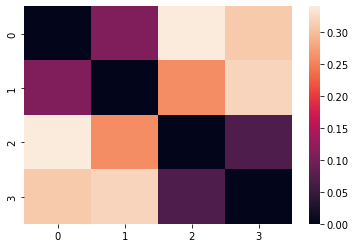

In [48]:
sns.heatmap(data=frame)

plt.show()